In [1]:
import pandas as pd
import numpy as np
import json

import pickle 
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.auto import tqdm

In [36]:
import matplotlib.pyplot as plt

In [24]:
import seaborn as sns
sns.set_style('darkgrid')

In [31]:
sns.set(rc={'figure.figsize':(11.7,6.27)})

In [2]:
import os
import glob
def read_lines(fn):
    if not os.path.exists(fn):
        return []
    with open(fn, 'r', encoding='utf-8') as f:
        text = f.read()
    lines = text.split("\n")
    if lines[-1] == '':
        return lines[:-1]
    else:
        return lines

def write_lines(fn, lines, mode='w'):
    text_to_write = "\n".join(list(lines)) 
    with open(fn, encoding='utf-8', mode=mode) as f:
        f.write(text_to_write)

In [179]:
def show_cos_src_tgt_dataset(df, min_cos_src_tgt_sim=0):
    return df[df["cos_src_tgt"] <= min_cos_src_tgt_sim].sort_values("cos_src_tgt")

def show_cos_check_dataset(df, min_cos_check_sim=0):
    return df[df["cos_check"] <= min_cos_check_sim].sort_values("cos_check")

def plot_cos_src_tgt(df, col="cos_src_tgt"):
    return df[df["text_src"] != df["text_tgt"]][col].plot.hist(bins=30)

def show_statistic(df, len_before=0, show_rate=True):
    diff_len = len_before - len(df)
    print("Count of rows: ", len(df))
    if diff_len > 0:
        print("Diff count: ", diff_len)
    if show_rate==True:
        print("Count of rows with change: ", df['have_change'].sum())
        print("Rate of rows with change: ", round(df['have_change'].mean(),2))
    print()

def basic_clean(df, show = True, min_cos_src_tgt_sim = 0):
    len_start = len(df)
    print("Initial statistics")
    df['have_change'] = (df['text_src']!=df['text_tgt']).astype(int)
    show_statistic(df, len_start)
    
    print("Drop dulicates")
    len_before = len(df)
    df = df.drop_duplicates(subset=['text_src', 'text_tgt'])
    show_statistic(df, len_before, show_rate=True)
    
    print("Drop where len less 5 and less then 1 token")
    len_before = len(df)
    df = df[df["text_tgt"].str.len() > 5]
    df = df[df['text_tgt'].apply(lambda x: len(x.split(" ")) > 1)]
    show_statistic(df, len_before, show_rate=True)
    
    print("Drop where start from non-capital")
    len_before = len(df)
    df = df[df["text_tgt"].apply(lambda x: x[0] == x[0].upper())]
    show_statistic(df, len_before, show_rate=True)
    
    
    print("Drop where all capital")
    len_before = len(df)
    df = df[df["text_tgt"].apply(lambda x: x != x.upper())]
    show_statistic(df, len_before, show_rate=True)
    
#     print("Drop where for one src more than one target")
#     len_before = len(df)
#     val_count = df.text_src.value_counts()
#     index_to_delete = []
#     for text_src in val_count[val_count > 1].index:
#         sub_df = df[df.text_src == text_src]
#         res_ind = sub_df[sub_df["cos_src_tgt"] > 0.999].index
#         if len(res_ind):
#             index_to_delete.extend(res_ind)
#     df = df[~df.index.isin(index_to_delete)]
#     show_statistic(df, len_before, show_rate=True)
    
    print("Drop where cosine similarity between src and tgt is less than ", min_cos_src_tgt_sim)
    len_before = len(df)
    df = df[df["cos_src_tgt"] > min_cos_src_tgt_sim]
    show_statistic(df, len_before, show_rate=True)
    
    print('Final rate of cleaned data: ', round(len(df)/len_start,2))
    return df

### WL 

In [5]:
text_src = read_lines("../../data_parallel/wi+locness/train_src")
text_tgt = read_lines("../../data_parallel/wi+locness/train_tgt")

with open("../Clustering/data/wl_train_src_embed.pickle", "rb") as f:
    vectors_src = pickle.load(f)

with open("../Clustering/data/wl_train_tgt_embed.pickle", "rb") as f:
    vectors_tgt = pickle.load(f)
    
cos_sim_wl = []
for i in tqdm(range(len(vectors_src))):
    cos_sim_wl.append(cosine_similarity([vectors_src[i]],[vectors_tgt[i]])[0,0])

In [233]:
import os
#os.listdir("../Clustering/data/")

In [234]:
with open("../Clustering/data/dump_wl.pickle", "rb") as f:
    dump_wl = pickle.load(f)

In [235]:
dump_wl.keys()

dict_keys(['vectors', 'texts', 'clusters', 'mean_vectors'])

In [6]:
wl_df = pd.DataFrame({"text_src": text_src, "text_tgt": text_tgt, "cos_src_tgt": cos_sim_wl})

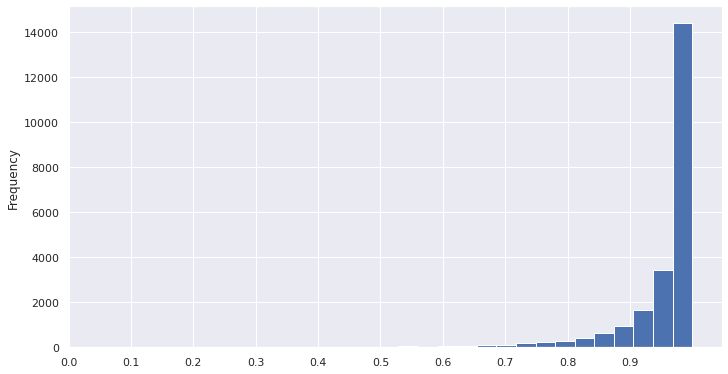

In [38]:
g = plot_cos_src_tgt(wl_df)
plt.xticks(np.arange(0, 1, 0.1))
plt.show()

In [149]:
wl_df[wl_df["cos_src_tgt"] <= 0.5].sort_values("cos_src_tgt")

,text_src,text_tgt,cos_src_tgt,have_change
2380,I am stydying envaermantal saents .,I am studying environmental science .,0.057646,1
2557,And terolism is scare also .,And terrorism is scarce also .,0.166419,1
13529,Good Morning :,Dear Sir / Madam,0.186326,1
5518,fsdjgdofg,,0.196443,1
23629,Rest is anything but completely different .,The rest is completely different .,0.201329,1
...,...,...,...,...
7325,we think it 's Improtant meal manners .,We think it 's important to respect meal manne...,0.491021,1
5124,Who brink up ?,Who brings us up ?,0.494233,1
5577,after two days poleas sow some boody in crime ...,"After two days , the police saw somebody at th...",0.494837,1
6848,coming to the infrastructure of the shuttle it...,"Coming to the infrastructure of badminton , it...",0.497197,1


In [236]:
clean_wl = basic_clean(wl_df, show = True, min_cos_src_tgt_sim=0.5)

Initial statistics
Count of rows:  34308
Count of rows with change:  22744
Rate of rows with change:  0.66

Drop dulicates
Count of rows:  33493
Diff count:  815
Count of rows with change:  22717
Rate of rows with change:  0.68

Drop where len less 5 and less then 1 token
Count of rows:  33202
Diff count:  291
Count of rows with change:  22698
Rate of rows with change:  0.68

Drop where start from non-capital
Count of rows:  32911
Diff count:  291
Count of rows with change:  22504
Rate of rows with change:  0.68

Drop where all capital
Count of rows:  32813
Diff count:  98
Count of rows with change:  22477
Rate of rows with change:  0.69

Drop where cosine similarity between src and tgt is less than  0.5
Count of rows:  32731
Diff count:  82
Count of rows with change:  22395
Rate of rows with change:  0.68

Final rate of cleaned data:  0.95


### Nucle

In [15]:
text_src = read_lines("../../data_parallel/nucle/nucle_src")
text_tgt = read_lines("../../data_parallel/nucle/nucle_tgt")

with open("../Clustering/data/nucle_train_src_embed.pickle", "rb") as f:
    vectors_src = pickle.load(f)

with open("../Clustering/data/nucle_train_tgt_embed.pickle", "rb") as f:
    vectors_tgt = pickle.load(f)
    
cos_sim = []
for i in tqdm(range(len(vectors_src))):
    cos_sim.append(cosine_similarity([vectors_src[i]],[vectors_tgt[i]])[0,0])

In [16]:
with open("../Checkpoint_exp/nucle_cos.pickle", "rb") as f:
    cos_check = pickle.load(f)

In [17]:
nucle_df = pd.DataFrame({"text_src": text_src, "text_tgt": text_tgt, "cos_src_tgt": cos_sim, "cos_check": cos_check})

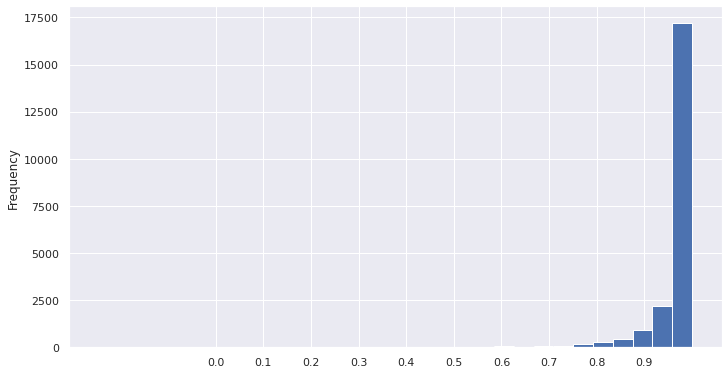

In [35]:
g = plot_cos_src_tgt(nucle_df)
plt.xticks(np.arange(0, 1, 0.1))
plt.show()

In [159]:
show_cos_src_tgt_dataset(nucle_df, min_cos_src_tgt_sim=0.5)

,text_src,text_tgt,cos_src_tgt,cos_check,have_change
14963,Even if a minority will have no intention to t...,.,-0.246615,0.974864,1
19124,It may be objected that despite great accommod...,,-0.228636,0.972713,1
27646,"Furthermore , the federal government ignored a...",,-0.216451,0.977595,1
30054,Normal employees are not inspirited also limit...,,-0.198910,0.973263,1
15812,This harsh behavior brings fear to adult who i...,,-0.188985,0.969514,1
...,...,...,...,...,...
28917,( Option 1 ) .,,0.480066,0.962951,1
4287,"Thus , due to the implications of many other p...","Thus , due to the implications of a positive g...",0.483054,0.977810,1
15281,"The ability of the government is limited , and...",The ability of the government is limited .,0.489685,0.975838,1
21473,"However for someone , this benefit is just the...","However for some people , this benefit is just",0.493156,0.976178,1


In [181]:
clean_nucle = basic_clean(nucle_df, show = True, min_cos_src_tgt_sim=0.5)

Initial statistics
Count of rows:  57151
Count of rows with change:  21834
Rate of rows with change:  0.38

Drop dulicates
Count of rows:  53681
Diff count:  3470
Count of rows with change:  21830
Rate of rows with change:  0.41

Drop where len less 5 and less then 1 token
Count of rows:  53275
Diff count:  406
Count of rows with change:  21575
Rate of rows with change:  0.4

Drop where start from non-capital
Count of rows:  52813
Diff count:  462
Count of rows with change:  21340
Rate of rows with change:  0.4

Drop where all capital
Count of rows:  52550
Diff count:  263
Count of rows with change:  21321
Rate of rows with change:  0.41

Drop where cosine similarity between src and tgt is less than  0.5
Count of rows:  52488
Diff count:  62
Count of rows with change:  21259
Rate of rows with change:  0.41

Final rate of cleaned data:  0.92


### FCE

In [40]:
text_src = read_lines("../../data_parallel/fce/fce_train_src")
text_tgt = read_lines("../../data_parallel/fce/fce_train_tgt")

with open("../Clustering/data/fce_train_src_embed.pickle", "rb") as f:
    vectors_src = pickle.load(f)

with open("../Clustering/data/fce_train_tgt_embed.pickle", "rb") as f:
    vectors_tgt = pickle.load(f)
    
cos_sim = []
for i in tqdm(range(len(vectors_src))):
    cos_sim.append(cosine_similarity([vectors_src[i]],[vectors_tgt[i]])[0,0])

In [41]:
with open("../Checkpoint_exp/fce_cos.pickle", "rb") as f:
    cos_check = pickle.load(f)

In [42]:
fce_df = pd.DataFrame({"text_src": text_src, "text_tgt": text_tgt, "cos_src_tgt": cos_sim, "cos_check": cos_check})

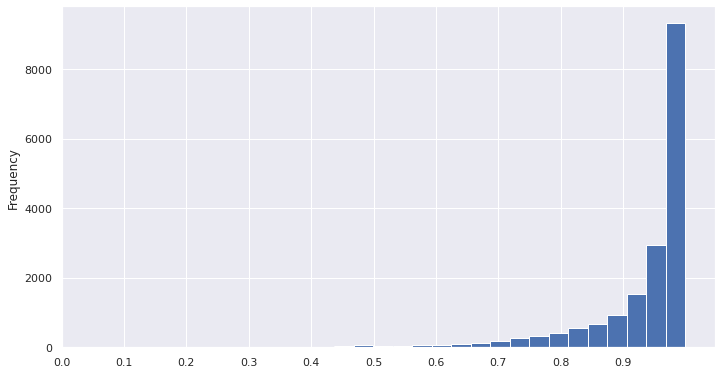

In [43]:
g = plot_cos_src_tgt(fce_df)
plt.xticks(np.arange(0, 1, 0.1))
plt.show()

In [155]:
show_cos_src_tgt_dataset(fce_df, min_cos_src_tgt_sim=0.5)

,text_src,text_tgt,cos_src_tgt,cos_check,have_change
18933,befor the beggining ?,before the beginning ?,0.061627,0.963681,1
25815,i was abset of it .,I was upset about it .,0.083509,0.977990,1
15235,It was alwais the saim .,It was always the same .,0.095632,0.974045,1
14886,Becaue,Because,0.147442,0.946754,1
17632,Staying in a que or croude is also unplesent .,Staying in a queue or crowd is also unpleasant .,0.157074,0.975612,1
...,...,...,...,...,...
7126,Yours sincerly,Yours sincerely,0.498015,0.895851,1
20112,Yours sincerly,Yours sincerely,0.498015,0.895851,1
25967,"Firstly , you did not tell the truth about sta...","Firstly , you did not tell the truth about the...",0.498453,0.979082,1
15874,Why not go to sock exchange ? ',Why not go to the stock exchange ? ',0.499613,0.978991,1


In [55]:
fce_df.loc[7278].values

array(['I would like to travel only in July because I will take some hollydays at this time .',
       'I would like to travel only in July because I will have some holiday at that time .',
       0.7999153137207031, 0.97819734, 1], dtype=object)

In [237]:
clean_fce = basic_clean(fce_df, show = True, min_cos_src_tgt_sim=0.5)

Initial statistics
Count of rows:  28350
Count of rows with change:  17742
Rate of rows with change:  0.63

Drop dulicates
Count of rows:  25707
Diff count:  2643
Count of rows with change:  17540
Rate of rows with change:  0.68

Drop where len less 5 and less then 1 token
Count of rows:  25550
Diff count:  157
Count of rows with change:  17523
Rate of rows with change:  0.69

Drop where start from non-capital
Count of rows:  25426
Diff count:  124
Count of rows with change:  17455
Rate of rows with change:  0.69

Drop where all capital
Count of rows:  25033
Diff count:  393
Count of rows with change:  17220
Rate of rows with change:  0.69

Drop where cosine similarity between src and tgt is less than  0.5
Count of rows:  24877
Diff count:  156
Count of rows with change:  17064
Rate of rows with change:  0.69

Final rate of cleaned data:  0.88


## Lang8

In [61]:
text_src = read_lines("../../data_parallel/lang8/lang8_src")
text_tgt = read_lines("../../data_parallel/lang8/lang8_tgt")

with open("../Clustering/data/lang8_train_src_embed.pickle", "rb") as f:
    vectors_src = pickle.load(f)

with open("../Clustering/data/lang8_train_tgt_embed.pickle", "rb") as f:
    vectors_tgt = pickle.load(f)
    
cos_sim = []
for i in tqdm(range(len(vectors_src))):
    cos_sim.append(cosine_similarity([vectors_src[i]],[vectors_tgt[i]])[0,0])

In [63]:
with open("../Checkpoint_exp/lang8_cos.pickle", "rb") as f:
    cos_check = pickle.load(f)

In [64]:
lang8_df = pd.DataFrame({"text_src": text_src, "text_tgt": text_tgt, "cos_src_tgt": cos_sim, "cos_check": cos_check})

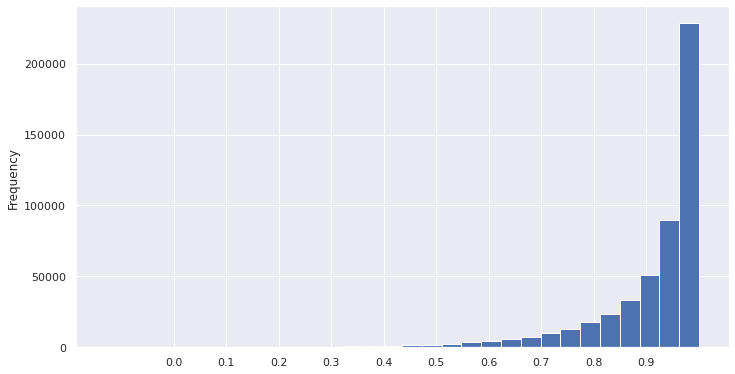

In [65]:
g = plot_cos_src_tgt(lang8_df)
plt.xticks(np.arange(0, 1, 0.1))
plt.show()

In [157]:
show_cos_src_tgt_dataset(lang8_df, min_cos_src_tgt_sim=0.5)

,text_src,text_tgt,cos_src_tgt,cos_check,have_change
300445,So I do easy to the society 's exchange .,I do n't understand this phrase .,-0.129838,0.976939,1
504480,is japanese holiday .,.,-0.107871,0.976343,1
620960,Because I like fish .,See above .,-0.077993,0.978164,1
746006,I can t explain how it ached . . .,kotoba ni naranai kurai itai . . .,-0.077581,0.976457,1
542854,The show started .,Incomplete sentence .,-0.069533,0.975724,1
...,...,...,...,...,...
38016,It was so fan : ),It was so fun : ),0.499790,0.978070,1
837511,"So , I would manage to write just on time .","So , I manage to write just one essay .",0.499823,0.981104,1
80969,How are yor ?,How are you ?,0.499925,0.969870,1
878999,I ca n't have a holiday in every weekend recen...,I 've had to work ( during ) every weekend rec...,0.499926,0.972759,1


In [67]:
lang8_df.loc[991930].values

array(['Actually , many companies lately try to establish new management systems by juggling teamwork and outstanding characters .',
       'Actually , lately many companies have recently been trying to establish new management systems by finding a balance between teamwork and individual success .',
       0.7999920845031738, 0.9709615], dtype=object)

In [238]:
clean_lang8 = basic_clean(lang8_df, show = True, min_cos_src_tgt_sim=0.5)

Initial statistics
Count of rows:  1037561
Count of rows with change:  499205
Rate of rows with change:  0.48

Drop dulicates
Count of rows:  950886
Diff count:  86675
Count of rows with change:  497292
Rate of rows with change:  0.52

Drop where len less 5 and less then 1 token
Count of rows:  941384
Diff count:  9502
Count of rows with change:  497039
Rate of rows with change:  0.53

Drop where start from non-capital
Count of rows:  886222
Diff count:  55162
Count of rows with change:  474060
Rate of rows with change:  0.53

Drop where all capital
Count of rows:  882613
Diff count:  3609
Count of rows with change:  473811
Rate of rows with change:  0.54

Drop where cosine similarity between src and tgt is less than  0.5
Count of rows:  876206
Diff count:  6407
Count of rows with change:  467404
Rate of rows with change:  0.53

Final rate of cleaned data:  0.84


In [71]:
import copy

In [164]:
orig_merge = copy.deepcopy(lang8_df)
orig_merge = orig_merge.append(nucle_df)
orig_merge = orig_merge.append(fce_df)
orig_merge = orig_merge.append(wl_df)

In [165]:
len(orig_merge)

1157370

In [167]:
orig_merge.have_change.sum()

561525

In [188]:
merge = copy.deepcopy(clean_lang8)
merge = merge.append(clean_nucle)
merge = merge.append(clean_fce)
merge = merge.append(clean_wl)

In [121]:
len(merge)

900143

In [123]:
merge.have_change.sum()

466971

In [162]:
len(merge)

990650

In [163]:
merge.have_change.sum()

528637

In [189]:
len(merge)

986302

In [190]:
merge.have_change.sum()

528122

### Split each dataset one by one

In [273]:
lang8_train, lang8_dev = train_test_split(clean_lang8, test_size=0.02, random_state=4, stratify=clean_lang8.have_change)
nucle_train, nucle_dev = train_test_split(clean_nucle, test_size=0.02, random_state=4, stratify=clean_nucle.have_change)
fce_train, fce_dev = train_test_split(clean_fce, test_size=0.02, random_state=4, stratify=clean_fce.have_change)
wl_train, wl_dev = train_test_split(clean_wl, test_size=0.02, random_state=4, stratify=clean_wl.have_change)

In [274]:
clean_merge_train = copy.deepcopy(lang8_train)
clean_merge_train = clean_merge_train.append(nucle_train)
clean_merge_train = clean_merge_train.append(fce_train)
clean_merge_train = clean_merge_train.append(wl_train)

In [275]:
clean_merge_dev = copy.deepcopy(lang8_dev)
clean_merge_dev = clean_merge_dev.append(nucle_dev)
clean_merge_dev = clean_merge_dev.append(fce_dev)
clean_merge_dev = clean_merge_dev.append(wl_dev)

In [276]:
clean_merge_train.head()

,text_src,text_tgt,cos_src_tgt,cos_check,have_change
345945,"When it snows , it often follows rain .","When it snows , it often follows rain .",1.000000,0.975039,0
941148,"He got rid of it , but took some photos for me...","He got rid of it , but took some photos for me...",1.000000,0.977283,0
679806,"Anyway , I have been really refreshed during m...","Anyway , I have been really refreshed during m...",1.000000,0.981497,0
768651,"Yesterday , After the tennis school finished ,...","Yesterday , after the tennis class finished , ...",0.975151,0.978811,1
707268,It 's first diary . . . : ),This is my first diary entry . . . : ),0.942790,0.978728,1


In [279]:
clean_merge_train["cos_check"] = clean_merge_train["cos_check"].fillna(1)

In [285]:
clean_merge_train = clean_merge_train.sort_values("cos_check")
clean_merge_train

,text_src,text_tgt,cos_src_tgt,cos_check,have_change
615345,- - - - - - - - - - - - - - - - - - - - - - - ...,- - - - - - - - - - - - - - - - - - - - - - - ...,1.000000,0.781497,0
480615,- - - - - - - - - - - - - - - - - - - - - - - ...,- - - - - - - - - - - - - - - - - - - - - - - ...,1.000000,0.781497,0
339061,- - - - - - - - - - - - - - - - - - - - - - - ...,- - - - - - - - - - - - - - - - - - - - - - - ...,1.000000,0.781497,0
212427,Diary - - - - - - - - - - - - - - - - - - - - ...,Diary - - - - - - - - - - - - - - - - - - - - ...,1.000000,0.806920,0
147403,* * * * * * * * * @ yahoo . co . jp,* * * * * * * * * @ yahoo . co . jp,1.000000,0.820208,0
...,...,...,...,...,...
7208,"Moreover , if you have a good ability you can ...","Moreover , if you have good ability , you can ...",0.986160,1.000000,1
18330,Most doctors recommend doing this .,Most doctors recommend doing this .,1.000000,1.000000,0
6204,Relatively some people unwilling join military...,Some people are unwilling to do military servi...,0.934567,1.000000,1
311,"( On those times there were diverse monster , ...","( In those times , there were diverse monsters...",0.963007,1.000000,1


In [286]:
train_src = clean_merge_train.text_src.values 
train_tgt = clean_merge_train.text_tgt.values 
dev_src = clean_merge_dev.text_src.values 
dev_tgt = clean_merge_dev.text_tgt.values 

In [287]:
path_save = "../../data_parallel/light_clean_gold_sorted/"

In [288]:
write_lines(path_save+"train_src", train_src, mode='w')
write_lines(path_save+"train_tgt", train_tgt, mode='w')
write_lines(path_save+"dev_src", dev_src, mode='w')
write_lines(path_save+"dev_tgt", dev_tgt, mode='w')

In [74]:
from sklearn.model_selection import train_test_split

In [75]:
train, dev = train_test_split(merge, test_size=0.02, random_state=4)

In [76]:
train_src = train.text_src.values 
train_tgt = train.text_tgt.values 
dev_src = dev.text_src.values 
dev_tgt = dev.text_tgt.values 

In [77]:
path_save = "../../data_parallel/base_clean_gold/"

In [78]:
write_lines(path_save+"train_src", train_src, mode='w')
write_lines(path_save+"train_tgt", train_tgt, mode='w')
write_lines(path_save+"dev_src", dev_src, mode='w')
write_lines(path_save+"dev_tgt", dev_tgt, mode='w')

### Clean with checkpoints

### FCE

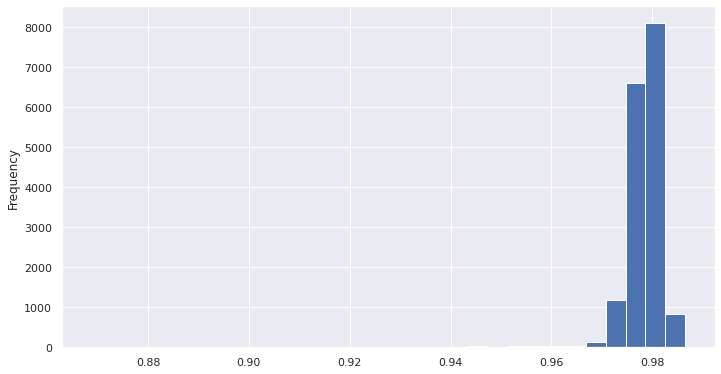

In [193]:
g = plot_cos_src_tgt(clean_fce, col="cos_check")

In [251]:
sh = show_cos_check_dataset(clean_fce, min_cos_check_sim=0.965)
sh[sh['have_change'] == 1]

,text_src,text_tgt,cos_src_tgt,cos_check,have_change
26590,Yours fainthfully,Yours faithfully,0.572759,0.868768,1
2843,Yours faightfully,Yours faithfully,0.544605,0.886463,1
4287,Yours sinecerely,Yours sincerely,0.688564,0.895373,1
12721,Your Sincerely,Yours sincerely,0.730466,0.906074,1
22863,Your Sincerely,Yours Faithfully,0.586604,0.906074,1
...,...,...,...,...,...
9049,We are look forward to hearing from you Yours ...,We are looking forward to hearing from you You...,0.996795,0.964354,1
3734,Certainly !,Really !,0.626817,0.964573,1
17422,Mrs Lemmings .,Mrs Lemmings,0.992129,0.964795,1
11604,""" What , you 're crazy . "" Charles responds .",""" What , you 're crazy ! "" Charles responds .",0.986575,0.964864,1


In [255]:
len(clean_fce)

24877

In [253]:
clean_fce_check = clean_fce[clean_fce["cos_check"] >= 0.965]

In [254]:
len(clean_fce_check)

23939

### Nucle

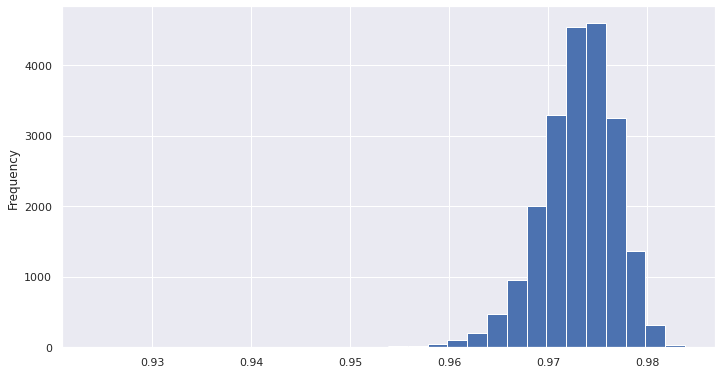

In [195]:
g = plot_cos_src_tgt(clean_nucle, col="cos_check")

In [250]:
sh = show_cos_check_dataset(clean_nucle, min_cos_check_sim=0.965)
sh[sh['have_change'] == 1]

,text_src,text_tgt,cos_src_tgt,cos_check,have_change
13024,"In Singapore , courses such as professional IT...","In Singapore , courses such as professional IT",0.557858,0.923826,1
55719,"( Ball , K. , Lyon , D. , Wood , D.M. , Norris...","( Ball , K. , Lyon et al 2006 ) .",0.817853,0.927680,1
14255,"In the USA , lawmakers led by Senator { Max Ba...","In the USA , lawmakers led by Senator { are ta...",0.720636,0.932153,1
7168,"( Khalik , S. ( 2009 , August 17 ) .","( Khalik , 2009 ) .",0.693716,0.934654,1
19799,""" CITATION Tan00 \ l 1033 ( Tanzi .",""" ( Tanzi .",0.695131,0.935369,1
...,...,...,...,...,...
39080,One possible counter measurement against human...,One possible counter measure against human err...,0.992751,0.964975,1
36958,Opponents of R&D funding for generation IV rea...,Opponents of R&D funding for generation IV rea...,0.997064,0.964977,1
43672,As a result of fewer fossil fuel supplies left...,As a result of fewer fossil fuel supplies left...,0.999218,0.964979,1
21808,"Welfare programs , such as free healthcare ser...","Welfare programs , such as free healthcare ser...",0.997533,0.964981,1


In [262]:
len(clean_nucle)

52488

In [260]:
clean_nucle_check = clean_nucle[clean_nucle["cos_check"] > 0.965]

In [261]:
len(clean_nucle_check)

45020

### Lang8

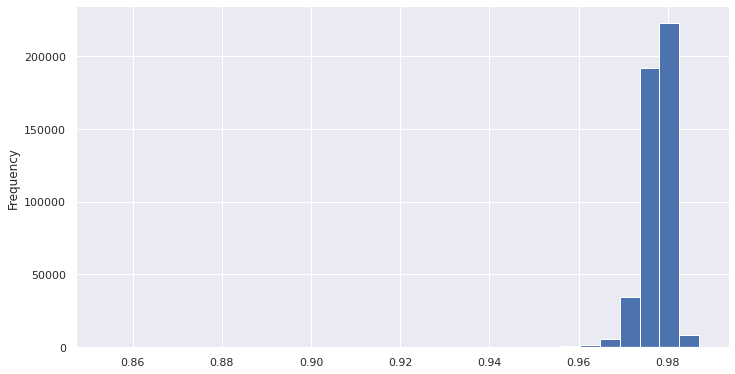

In [200]:
g = plot_cos_src_tgt(clean_lang8, col="cos_check")

In [263]:
sh = show_cos_check_dataset(clean_lang8, min_cos_check_sim=0.965)
sh[sh['have_change'] == 1]

,text_src,text_tgt,cos_src_tgt,cos_check,have_change
205257,EXTRAVAGANCE,EXTRAVAGANCE Extravagance,0.916300,0.853863,1
1030441,Introduction,Introduction .,0.982334,0.866819,1
367736,SLUNG,SLUNG Slang,0.778149,0.881431,1
848187,hello ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ...,Hello ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ...,0.938659,0.884925,1
970168,CONCEIVE,CONCEIVE v . ENVISION,0.665463,0.887579,1
...,...,...,...,...,...
489446,hoohoo .,Hoohoo .,0.944078,0.964992,1
645241,Too straight,Too direct,0.738044,0.964994,1
218309,good night,Good night .,0.969680,0.964994,1
856710,good night,Good night,0.957409,0.964994,1


In [264]:
len(clean_lang8)

876206

In [265]:
clean_lang8_check = clean_lang8[clean_lang8["cos_check"] > 0.965]

In [266]:
len(clean_lang8_check)

852775

In [267]:
lang8_train, lang8_dev = train_test_split(clean_lang8_check, test_size=0.02, random_state=4, stratify=clean_lang8_check.have_change)
nucle_train, nucle_dev = train_test_split(clean_nucle_check, test_size=0.02, random_state=4, stratify=clean_nucle_check.have_change)
fce_train, fce_dev = train_test_split(clean_fce_check, test_size=0.02, random_state=4, stratify=clean_fce_check.have_change)
wl_train, wl_dev = train_test_split(clean_wl, test_size=0.02, random_state=4, stratify=clean_wl.have_change)

In [268]:
clean_merge_train = copy.deepcopy(lang8_train)
clean_merge_train = clean_merge_train.append(nucle_train)
clean_merge_train = clean_merge_train.append(fce_train)
clean_merge_train = clean_merge_train.append(wl_train)

In [269]:
clean_merge_dev = copy.deepcopy(lang8_dev)
clean_merge_dev = clean_merge_dev.append(nucle_dev)
clean_merge_dev = clean_merge_dev.append(fce_dev)
clean_merge_dev = clean_merge_dev.append(wl_dev)

In [270]:
train_src = clean_merge_train.text_src.values 
train_tgt = clean_merge_train.text_tgt.values 
dev_src = clean_merge_dev.text_src.values 
dev_tgt = clean_merge_dev.text_tgt.values 

In [271]:
path_save = "../../data_parallel/check_gold_0965/"

In [272]:
write_lines(path_save+"train_src", train_src, mode='w')
write_lines(path_save+"train_tgt", train_tgt, mode='w')
write_lines(path_save+"dev_src", dev_src, mode='w')
write_lines(path_save+"dev_tgt", dev_tgt, mode='w')

In [127]:
merge_check = copy.deepcopy(clean_lang8_check)
merge_check = merge_check.append(clean_nucle_check)
merge_check = merge_check.append(clean_fce_check)
merge_check = merge_check.append(clean_wl)

In [128]:
len(merge_check)

681202

In [129]:
merge_check.have_change.sum()

392061

In [131]:
train, dev = train_test_split(merge_check, test_size=0.02, random_state=4)

In [132]:
train_src = train.text_src.values 
train_tgt = train.text_tgt.values 
dev_src = dev.text_src.values 
dev_tgt = dev.text_tgt.values 

In [134]:
path_save = "../../data_parallel/check_clean_gold/"

In [135]:
write_lines(path_save+"train_src", train_src, mode='w')
write_lines(path_save+"train_tgt", train_tgt, mode='w')
write_lines(path_save+"dev_src", dev_src, mode='w')
write_lines(path_save+"dev_tgt", dev_tgt, mode='w')